# Clasificador de Lesiones Cutáneas - Notebook Procesamiento de Úlceras

In [1]:
# Importamos las librerías necesarias
import numpy as np
import matplotlib.pyplot as plt
import cv2
import skimage.morphology as morph

In [2]:
def show_img_channel_and_histogram(img_channel, channel_name = 'Channel'):
    fig, axes = plt.subplots(1,2, figsize=(10,5))
    axes[0].imshow(img_channel, cmap='gray')
    axes[0].set_title(channel_name)
    axes[1].hist(img_channel.ravel(), bins=(np.max(img_channel) - np.min(img_channel)), density=True)
    axes[1].set_title('Histogram');

def show_img_mask_and_segmentation(img, mask, segmentation):
    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize = (20,16))
    ax1.imshow(img)
    ax1.set_title('Original')
    ax2.imshow(mask, cmap='gray')
    ax2.set_title('Mask')
    ax3.imshow(segmentation)
    ax3.set_title('Segmentation');

A continuación vamos a segmentar cada una de las imágenes para construir nuestro dataset de úlceras para el proyecto. Cabe destacar que el código repetitivo de gráficar cada canal de color en diversos espacios de color para analizar rutas de segmentación se omite, ya que se desarrolló un script que mantiene una interfaz gráfica para hacer esta tarea y ahorrar enormes cantidades de código

## #1. U1

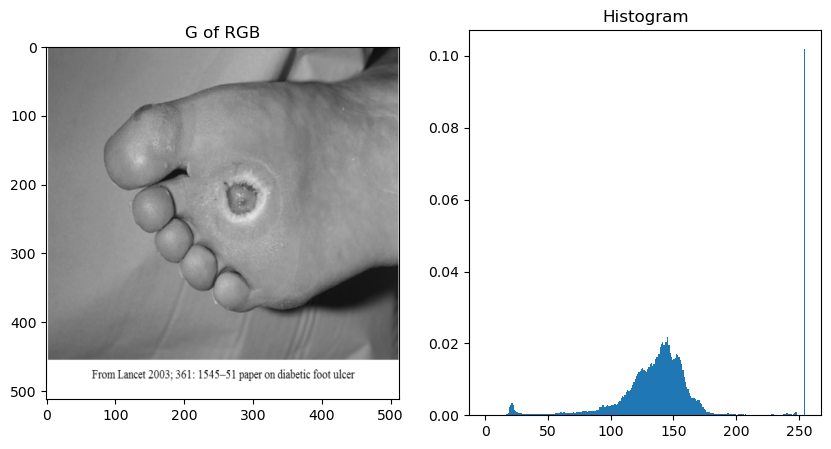

In [3]:
# Leemos la imagen
u1 = cv2.imread('Ulcers/U1.png')
u1_rgb = cv2.cvtColor(u1, cv2.COLOR_BGR2RGB)

# Tras analizar en los diversos espacios de color, se ha decidido trabajar en el espacio de color G del RGB y M de CMY
u1_g = u1[:,:,1].copy()

# Gráficamos ahora su histograma
show_img_channel_and_histogram(u1_g, 'G of RGB')

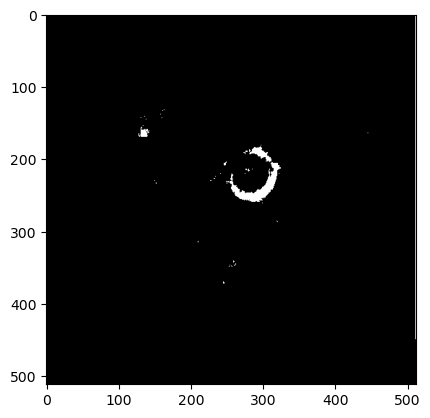

In [4]:
# Aplicamos un umbral para tomar la parte blancuzca que rodea la lesion
_, u1_g_thr = cv2.threshold(u1_g, 185, 255, cv2.THRESH_BINARY)
u1_g_thr[450:,:] = 0
u1_g_thr[:,:20] = 0
plt.imshow(u1_g_thr, cmap='gray');

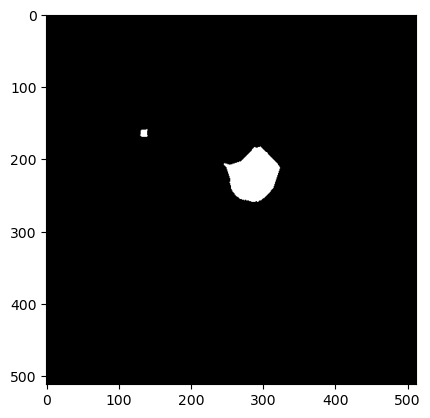

In [5]:
# Ahora usamos la operación de cierre para eliminar el ruido
se = morph.disk(7)
u1_g_thr_op = cv2.morphologyEx(u1_g_thr, cv2.MORPH_OPEN, morph.disk(1), iterations=1)
u1_g_thr_cl = cv2.morphologyEx(u1_g_thr_op, cv2.MORPH_CLOSE, se, iterations=5)
plt.imshow(u1_g_thr_cl, cmap='gray');

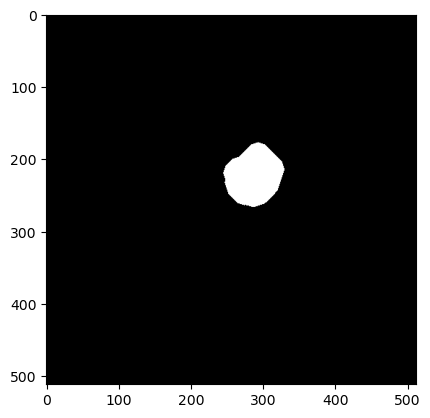

In [6]:
# Hacemos erosion para limpiar
u1_g_thr_cl_er = cv2.erode(u1_g_thr_cl, se, iterations=2)
# Y ahora una dilatación para mejorar la mascara
u1_mask = cv2.dilate(u1_g_thr_cl_er, se, iterations=3) > 127
plt.imshow(u1_mask, cmap='gray');

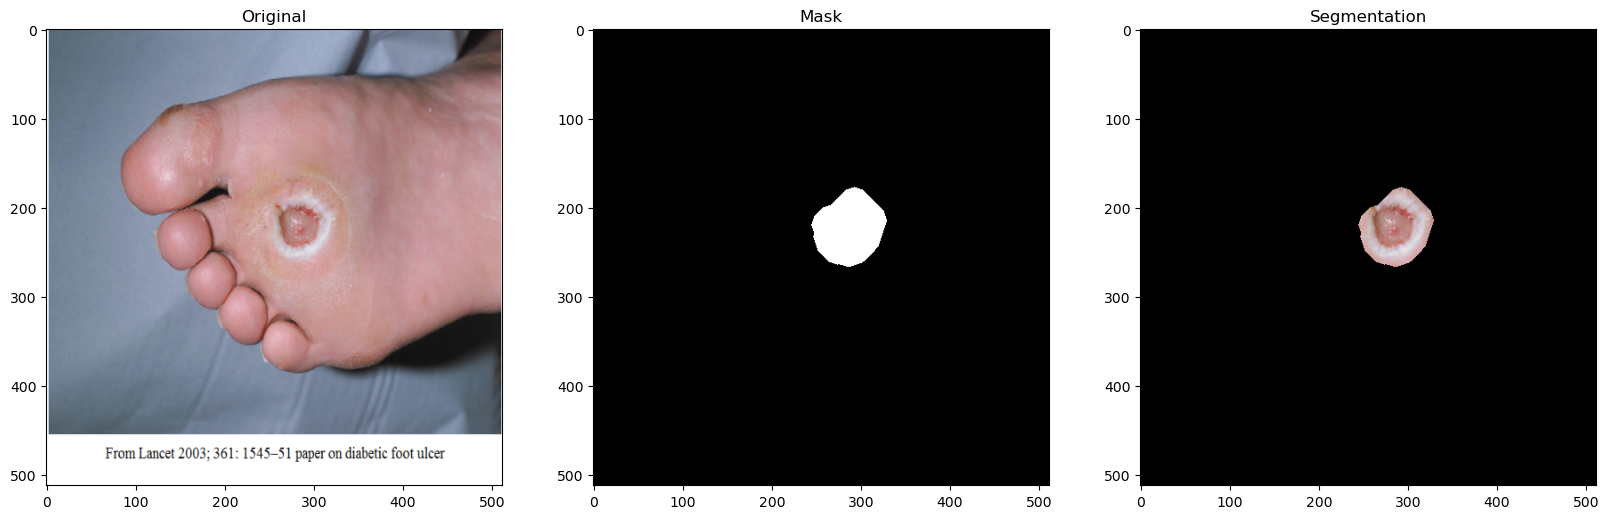

In [7]:
""" RESULTADO FINAL """
# Aplicamos la máscara y segmentamos
u1_segmented = u1_rgb * u1_mask[:,:,np.newaxis]
show_img_mask_and_segmentation(u1_rgb, u1_mask, u1_segmented)

## #2. U2

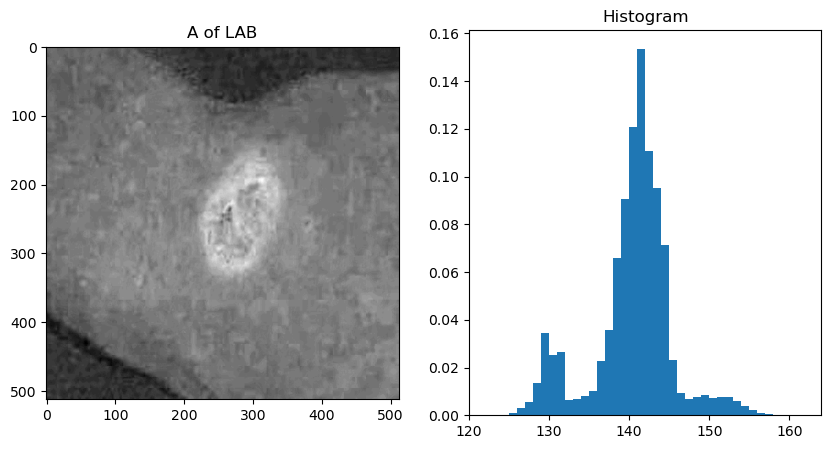

In [8]:
# Leemos la imagen
u2 = cv2.imread('Ulcers/U2.jpg')
u2_rgb = cv2.cvtColor(u2, cv2.COLOR_BGR2RGB)

# Tras analizar en los diversos espacios de color, se ha decidido trabajar en el espacio de color A del LAB
u2_a = cv2.cvtColor(u2, cv2.COLOR_BGR2LAB)[:,:,1]

# Gráficamos ahora su histograma
show_img_channel_and_histogram(u2_a, 'A of LAB')

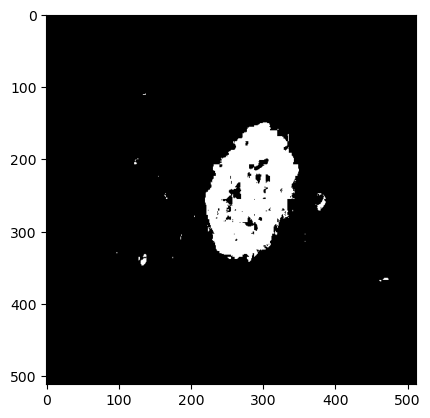

In [9]:
# Aplicamos un umbral más o menos mayor a 146, ya que la zona de la lesión es de una intensidad mayor
_, u2_a_thr = cv2.threshold(u2_a, 146, 255, cv2.THRESH_BINARY)
plt.imshow(u2_a_thr, cmap='gray');

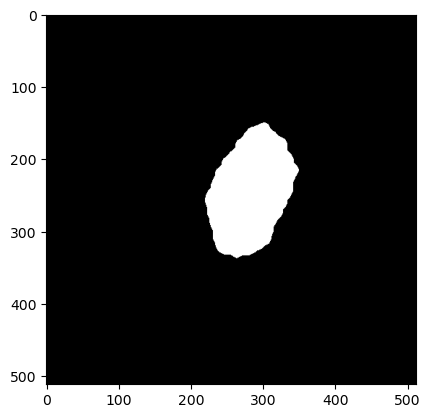

In [10]:
# Ahora aplicamos operaciones morfológicas, comenzando por una de apertura para limpiar la imagen
se2 = morph.disk(3)
u2_a_thr_op = cv2.morphologyEx(u2_a_thr, cv2.MORPH_OPEN, se2, iterations=2)

# Vamos ahora con una de cierre para mejorar la máscara de segmentación
se2 = morph.ellipse(5, 5)
u2_mask = cv2.morphologyEx(u2_a_thr_op, cv2.MORPH_CLOSE, se2, iterations=2) > 127
plt.imshow(u2_mask, cmap='gray');

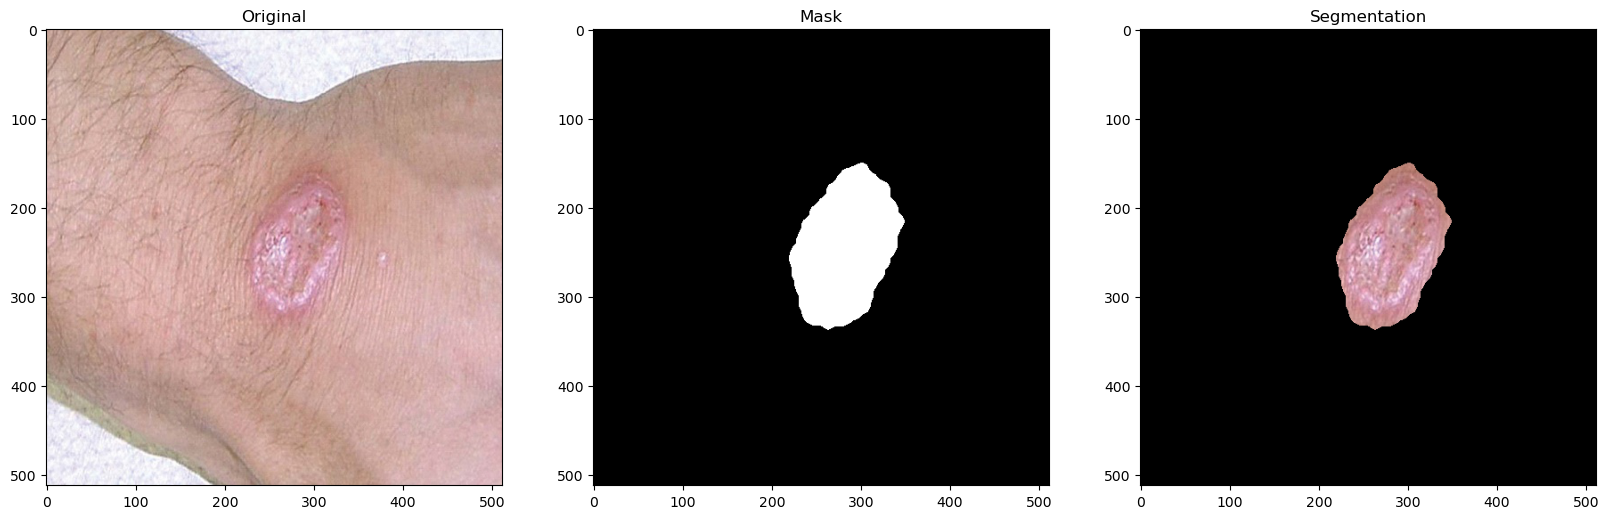

In [11]:
""" RESULTADO FINAL """
# Aplicamos la máscara y segmentamos
u2_segmented = u2_rgb * u2_mask[:,:,np.newaxis]
show_img_mask_and_segmentation(u2_rgb, u2_mask, u2_segmented)

## #3. U3

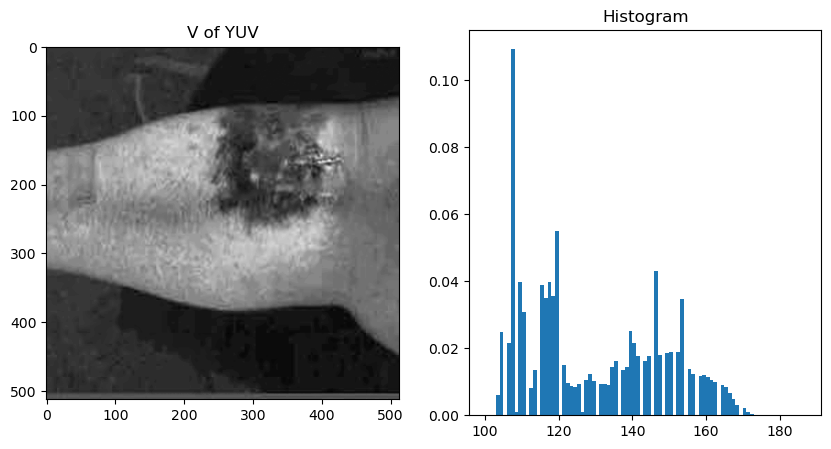

In [12]:
# Leemos la imagen
u3 = cv2.imread('Ulcers/U3.jpg')
u3_rgb = cv2.cvtColor(u3, cv2.COLOR_BGR2RGB)

# Tras analizar en los diversos espacios de color, se ha decidido trabajar en el espacio de color V del YUV
u3_v = cv2.cvtColor(u3, cv2.COLOR_BGR2YUV)[:,:,2]

# Gráficamos ahora su histograma
show_img_channel_and_histogram(u3_v, 'V of YUV')

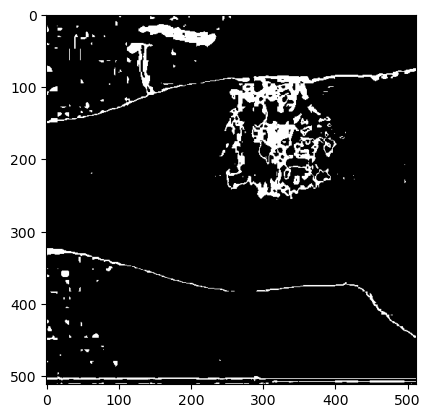

In [13]:
# Aplicamos un umbral bilateral estimando valores a partir del histograma para tomar la parte negra de la lesión
_, u3_v_thr1 = cv2.threshold(u3_v, 120, 255, cv2.THRESH_BINARY)
_, u3_v_thr2 = cv2.threshold(u3_v, 127, 255, cv2.THRESH_BINARY_INV)
u3_v_thr = cv2.bitwise_and(u3_v_thr1, u3_v_thr2)
plt.imshow(u3_v_thr, cmap='gray');

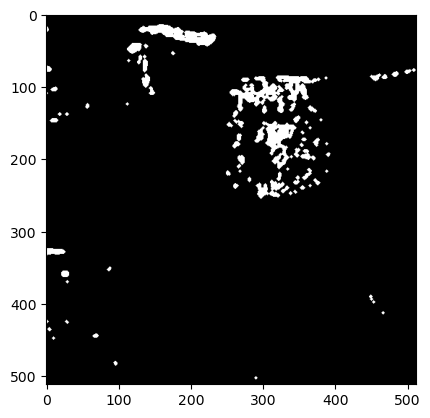

In [14]:
# Vamos ahora a aplicar operaciones morfológicas para mejorar la máscara, comenzando por una de apertura
se3 = morph.disk(2)
u3_v_thr_op = cv2.morphologyEx(u3_v_thr, cv2.MORPH_OPEN, se3, iterations=1)
plt.imshow(u3_v_thr_op, cmap='gray');

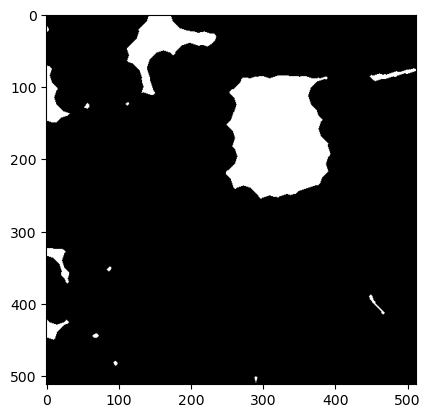

In [15]:
# Ahora aplicamos cierre para unir los pixeles de la lesión
se3 = morph.disk(7)
u3_v_thr_cl = cv2.morphologyEx(u3_v_thr_op, cv2.MORPH_CLOSE, se3, iterations=3)
plt.imshow(u3_v_thr_cl, cmap='gray');

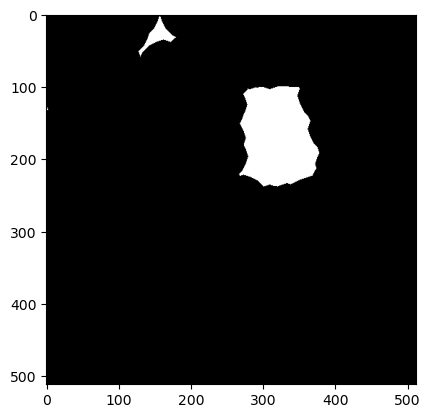

In [16]:
# Aplicamos ahora una erosión para limpiar la máscara
se3 = morph.disk(3)
u3_v_ero = cv2.erode(u3_v_thr_cl, se3, iterations=5)
plt.imshow(u3_v_ero, cmap='gray');

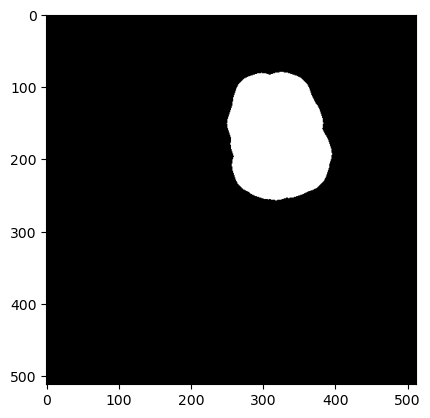

In [17]:
se3 = morph.disk(20)
u3_v_thr_op2 = cv2.morphologyEx(u3_v_ero, cv2.MORPH_OPEN, se3, iterations=1)
u3_mask = cv2.dilate(u3_v_thr_op2, morph.disk(5), iterations=4)
plt.imshow(u3_mask, cmap='gray');

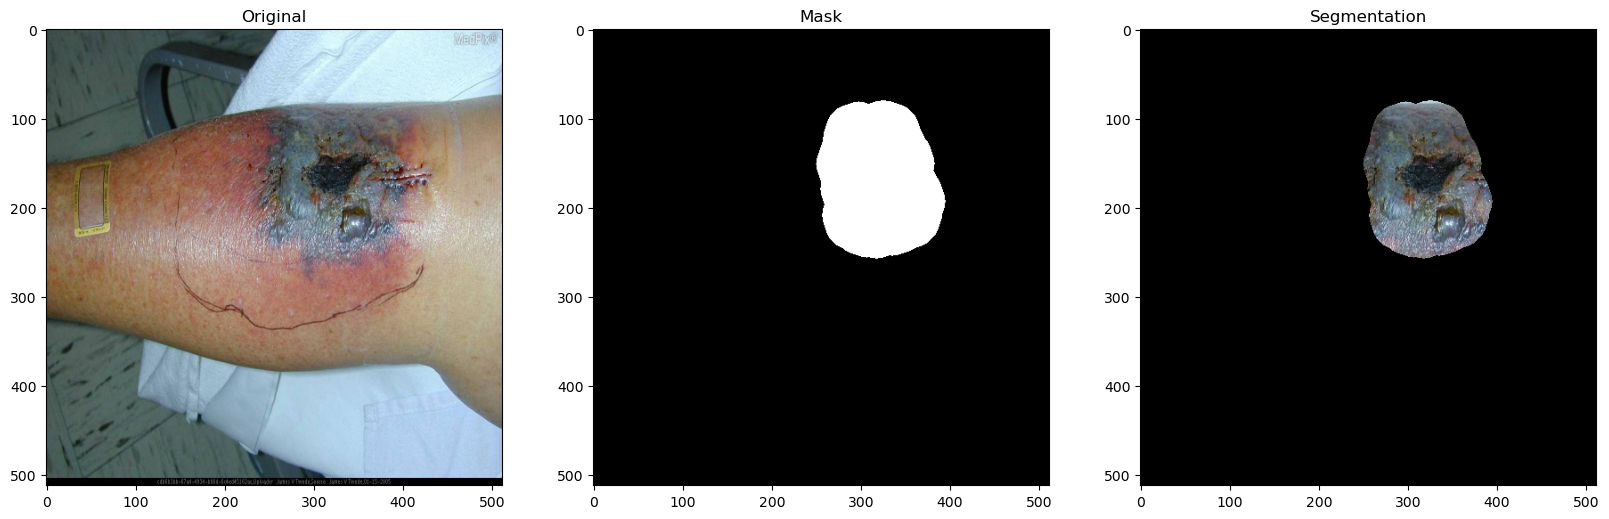

In [18]:
""" RESULTADO FINAL """
# Aplicamos la máscara y segmentamos
u3_mask = u3_mask > 127
u3_segmented = u3_rgb * u3_mask[:,:,np.newaxis]
show_img_mask_and_segmentation(u3_rgb, u3_mask, u3_segmented)

## #4. U4

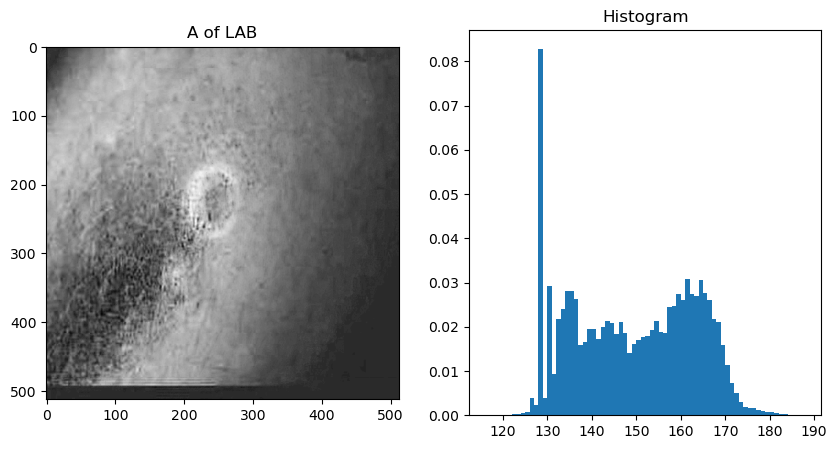

In [19]:
u4 = cv2.imread('Ulcers/U4.jpg')
u4_rgb = cv2.cvtColor(u4, cv2.COLOR_BGR2RGB)

# Se decide tras analizar los canales de color con el script, escoger el canal A del LAB
u4_a = cv2.cvtColor(u4, cv2.COLOR_BGR2LAB)[:,:,1]

show_img_channel_and_histogram(u4_a, 'A of LAB')

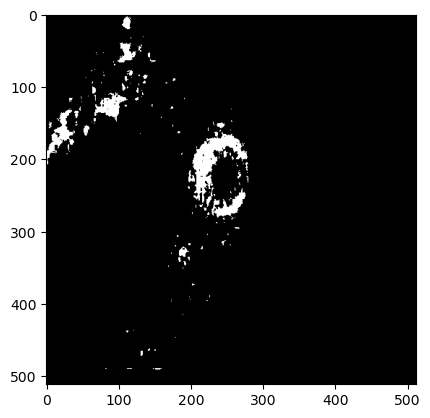

In [20]:
# Como la lesión es de alta intensidad, aplicamos un umbral de 174
_, u4_a_thr = cv2.threshold(u4_a, 170, 255, cv2.THRESH_BINARY)
plt.imshow(u4_a_thr, cmap='gray');

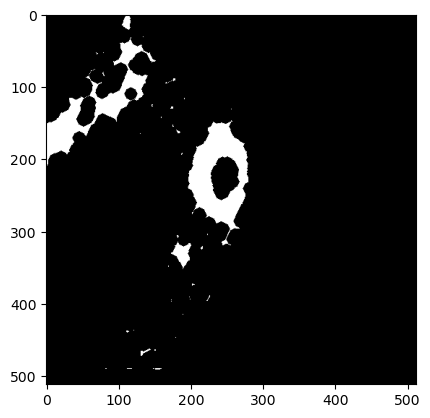

In [21]:
# Aplicamos ahora una operación morfológica de cierre para precisamente cerrar el área de la lesión
se4 = morph.disk(3)
u4_a_thr_cl = cv2.morphologyEx(u4_a_thr, cv2.MORPH_CLOSE, se4, iterations=3)
plt.imshow(u4_a_thr_cl, cmap='gray');

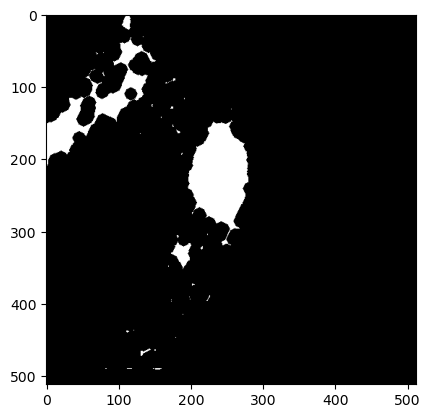

In [22]:
# Aplicamos un floodfill para rellenar el área de la lesión
u4_a_flood = morph.flood_fill(u4_a_thr_cl, (250,240), 255)
plt.imshow(u4_a_flood, cmap='gray');

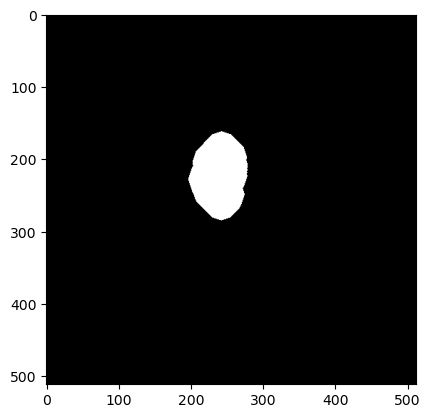

In [23]:
# Ahora aplicamoos una operación de apertura para limpiar la imagen
se4 = morph.disk(7)
u4_a_op = cv2.morphologyEx(u4_a_flood, cv2.MORPH_OPEN, se4, iterations=4)
plt.imshow(u4_a_op, cmap='gray');

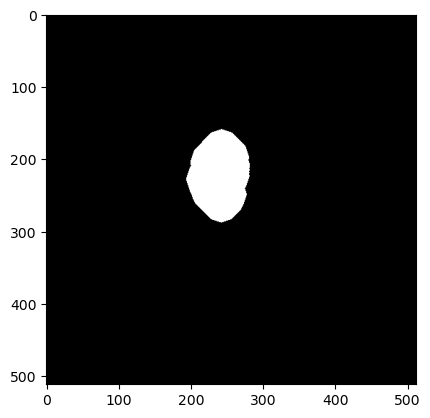

In [24]:
# Aplicamos una pequeña dilatación para mejorar la máscara
u4_mask = cv2.dilate(u4_a_op, morph.disk(3), iterations=1) > 127
plt.imshow(u4_mask, cmap='gray');

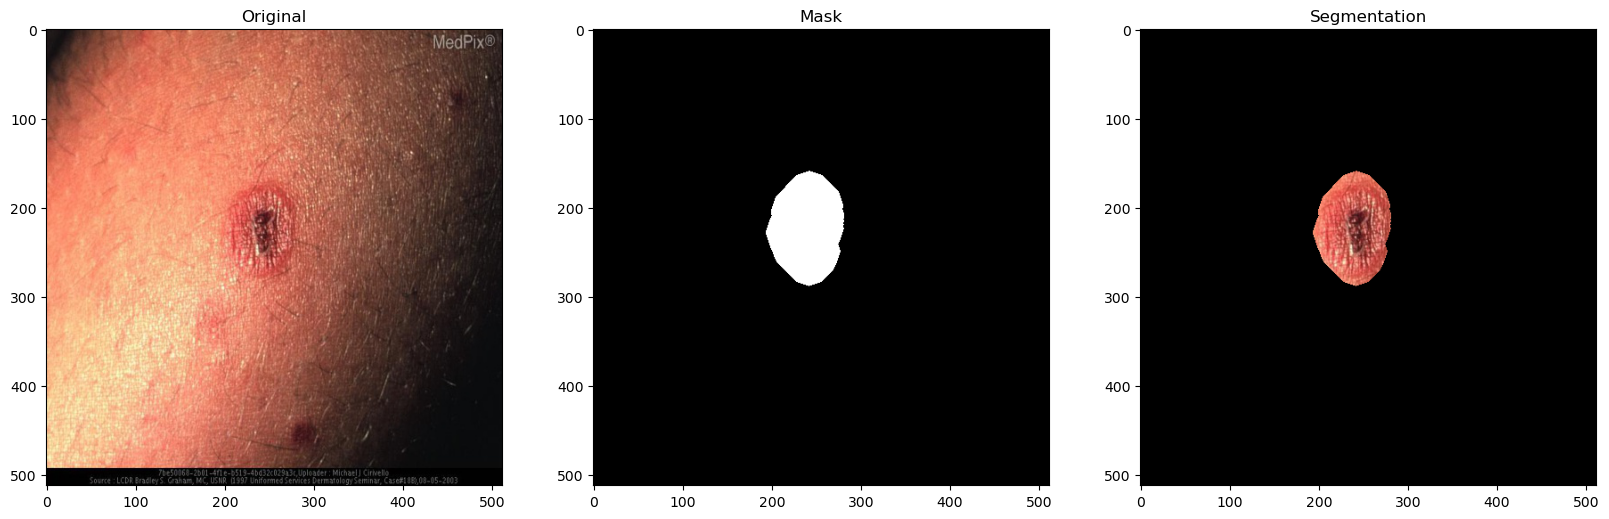

In [25]:
""" RESULTADO FINAL """
# Aplicamos la máscara y segmentamos
u4_segmented = u4_rgb * u4_mask[:,:,np.newaxis]
show_img_mask_and_segmentation(u4_rgb, u4_mask, u4_segmented)

## #5. U5

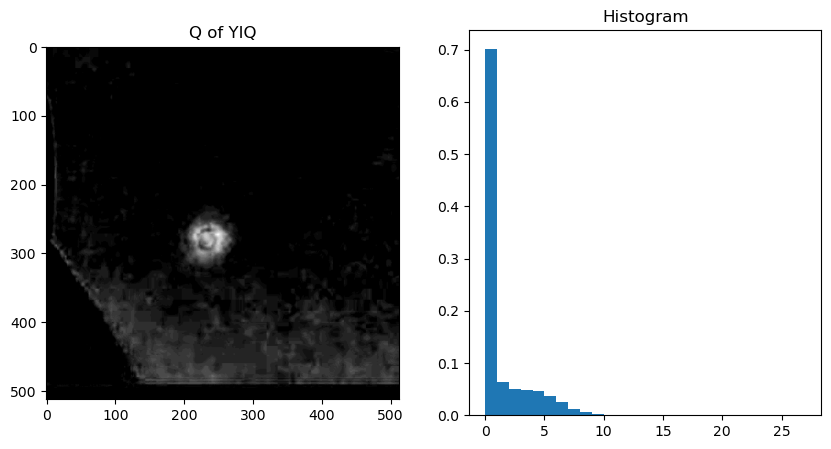

In [26]:
u5 = cv2.imread('Ulcers/U5.jpg')
u5_rgb = cv2.cvtColor(u5, cv2.COLOR_BGR2RGB)

# Se decide tras analizar los canales de color con el script, escoger el canal Q del YIQ
u5_q = np.clip((0.212*u5_rgb[:,:,0] - 0.523*u5_rgb[:,:,1] + 0.311*u5_rgb[:,:,2]), 0, 255).astype(np.uint8)

show_img_channel_and_histogram(u5_q, 'Q of YIQ')

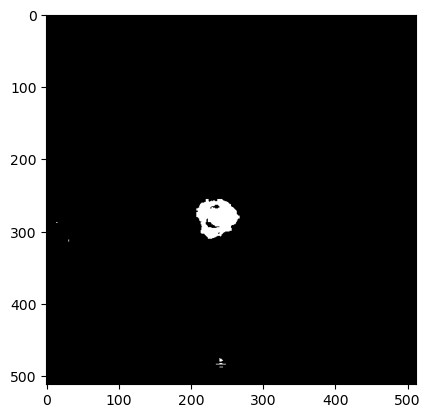

In [27]:
# La umbralización está muy sencilla, aplicamos una de 8
_, u5_q_thr = cv2.threshold(u5_q, 9, 255, cv2.THRESH_BINARY)
plt.imshow(u5_q_thr, cmap='gray');

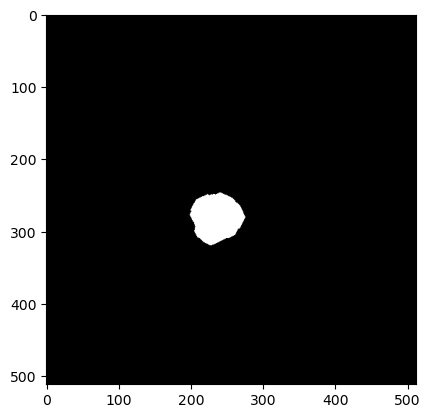

In [28]:
# Con operaiones morfológicas, limpiamos la imagen
se5 = morph.disk(3)
u5_q_op = cv2.morphologyEx(u5_q_thr, cv2.MORPH_OPEN, se5, iterations=1)
# Y ahora para pulir la máscara, aplicamos una de dilatación
se5 = morph.disk(3)
u5_mask = cv2.morphologyEx(u5_q_op, cv2.MORPH_DILATE, se5, iterations=3) > 127
plt.imshow(u5_mask, cmap='gray');

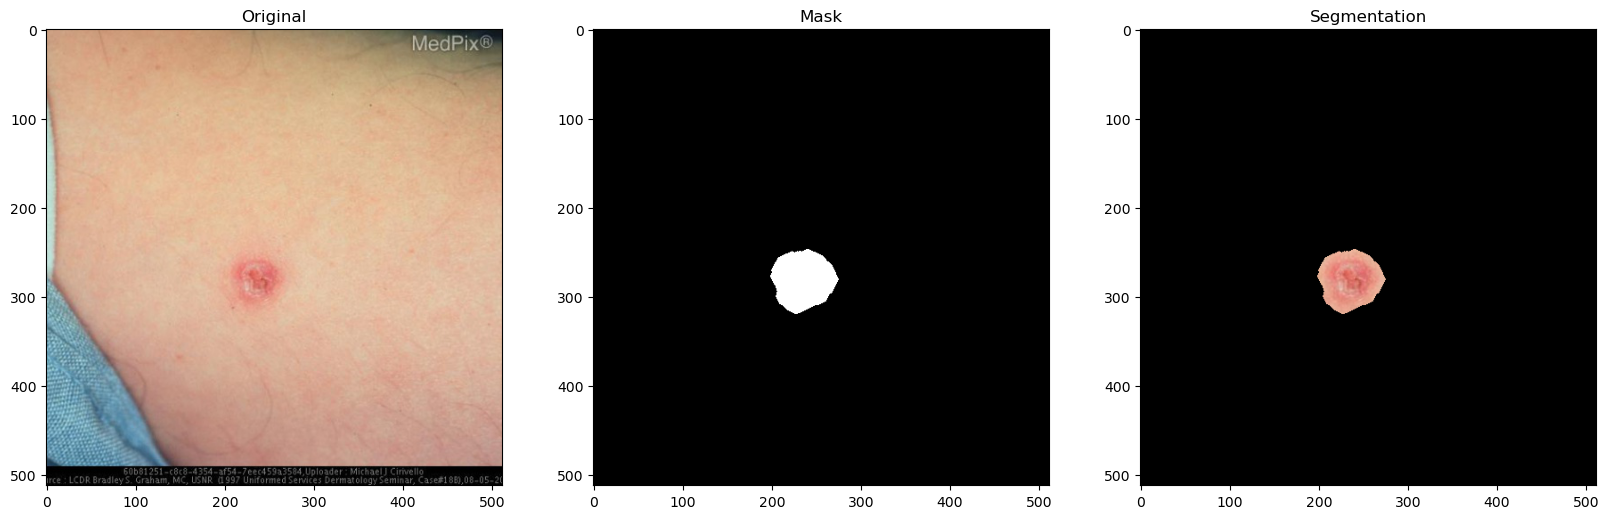

In [29]:
""" RESULTADO FINAL """
# Aplicamos la máscara y segmentamos
u5_segmented = u5_rgb * u5_mask[:,:,np.newaxis]
show_img_mask_and_segmentation(u5_rgb, u5_mask, u5_segmented)

## #6. U6

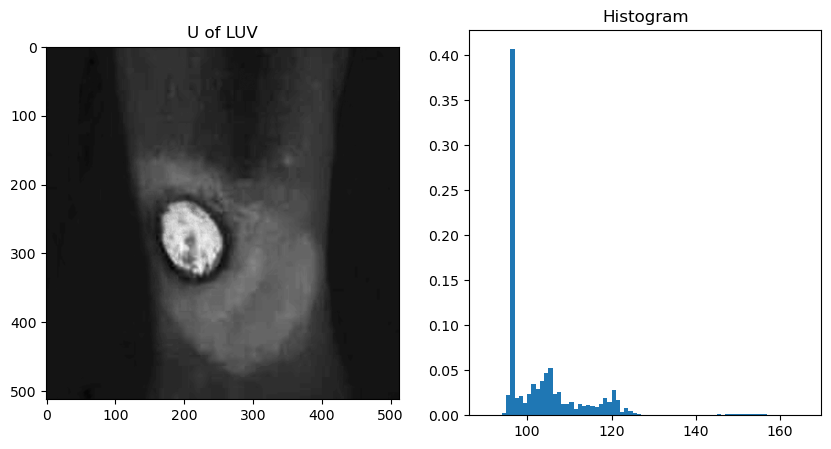

In [30]:
u6 = cv2.imread('Ulcers/U6.jpg')
u6_rgb = cv2.cvtColor(u6, cv2.COLOR_BGR2RGB)

# Se decide tras analizar los canales de color con el script, escoger el canal U de LUV
u6_u = cv2.cvtColor(u6, cv2.COLOR_BGR2LUV)[:,:,1]
show_img_channel_and_histogram(u6_u, 'U of LUV')

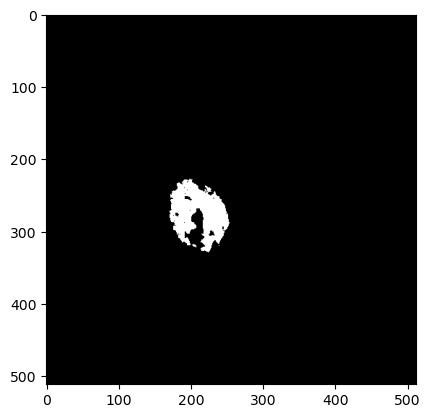

In [31]:
# La lesión cutánea tiene una alta intensidad, aplicamos entonces un umbral grande donde le histograma muestra unos pocos pixeles luego de 140
_, u6_u_thr = cv2.threshold(u6_u, 140, 255, cv2.THRESH_BINARY)
plt.imshow(u6_u_thr, cmap='gray');

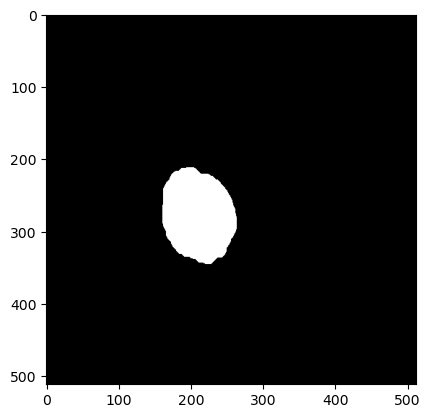

In [32]:
# Operación de cierre para mejorar la máscara
se6 = morph.ellipse(5, 7)
u6_u_thr_cl = cv2.morphologyEx(u6_u_thr, cv2.MORPH_CLOSE, se6, iterations=3)
# Aplicamos ahora un dilatación con estructura de elipse para mejorar la máscara
u6_mask = cv2.dilate(u6_u_thr_cl, morph.ellipse(5, 8), iterations=2) > 127
plt.imshow(u6_mask, cmap='gray');

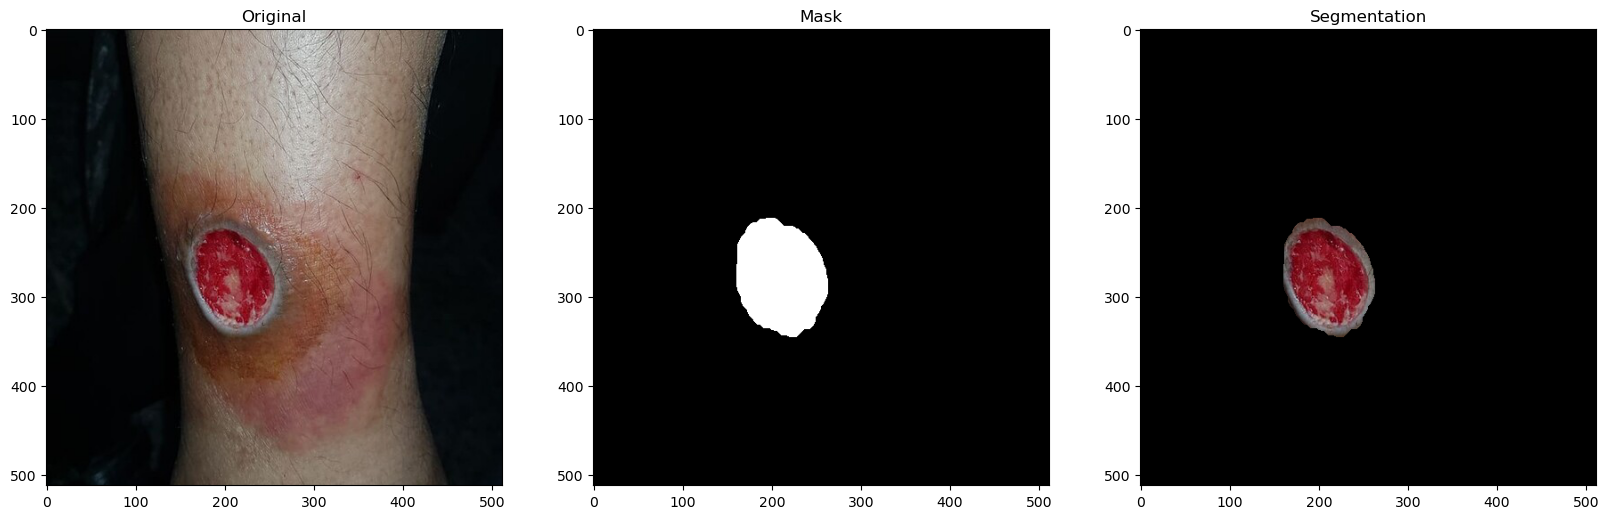

In [33]:
""" RESULTADO FINAL """
# Aplicamos la máscara y segmentamos
u6_segmented = u6_rgb * u6_mask[:,:,np.newaxis]
show_img_mask_and_segmentation(u6_rgb, u6_mask, u6_segmented)

## #7. U7

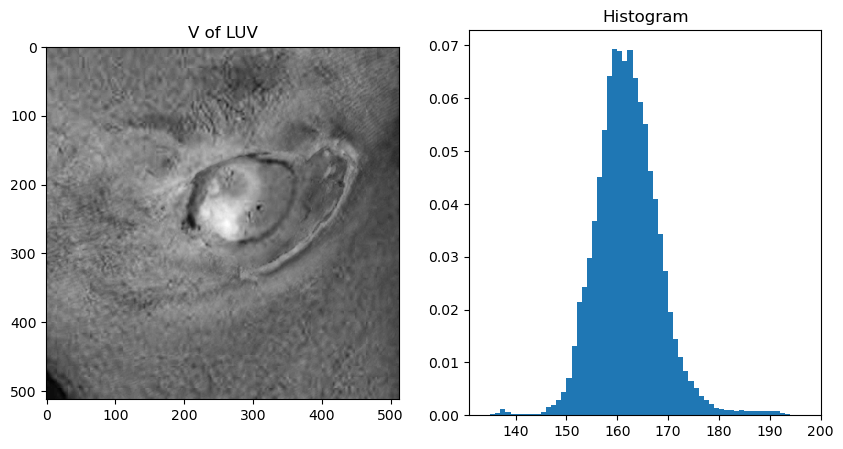

In [34]:
u7 = cv2.imread('Ulcers/U7.jpg')
u7_rgb = cv2.cvtColor(u7, cv2.COLOR_BGR2RGB)

# Se decide tras analizar los canales de color con el script, escoger el canal V de LUV
u7_v = cv2.cvtColor(u7, cv2.COLOR_BGR2LUV)[:,:,2]
show_img_channel_and_histogram(u7_v, 'V of LUV')

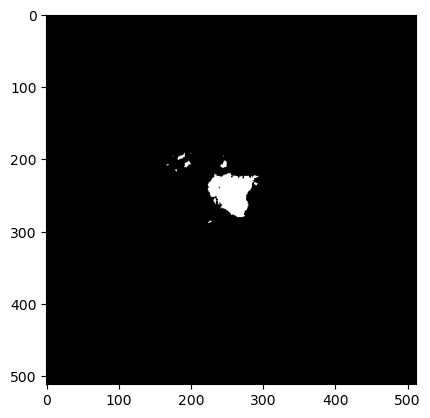

In [67]:
# Umbralizamos buscando rescatar la parte más intensa de la lesión
_, u7_v_thr = cv2.threshold(u7_v, 180, 255, cv2.THRESH_BINARY)
plt.imshow(u7_v_thr, cmap='gray');

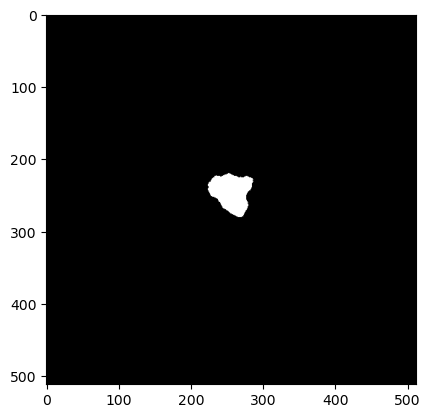

In [68]:
# Usamos una pequeña apertura para limpiar la imagen
se7 = morph.disk(3)
u7_v_op = cv2.morphologyEx(u7_v_thr, cv2.MORPH_OPEN, se7, iterations=1)
# Seguido de un cierre para mejorar la máscara
u7_v_cl = cv2.morphologyEx(u7_v_op, cv2.MORPH_CLOSE, se7, iterations=2)
plt.imshow(u7_v_cl, cmap='gray');

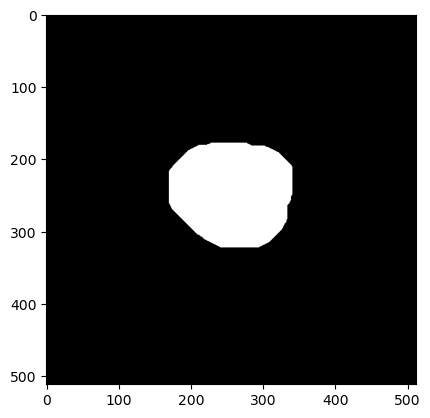

In [71]:
# APlicamos ahora dilateciones para mejorar la máscara
u7_mask = cv2.dilate(u7_v_cl, morph.ellipse(9,7), iterations=6) > 127
plt.imshow(u7_mask, cmap='gray');

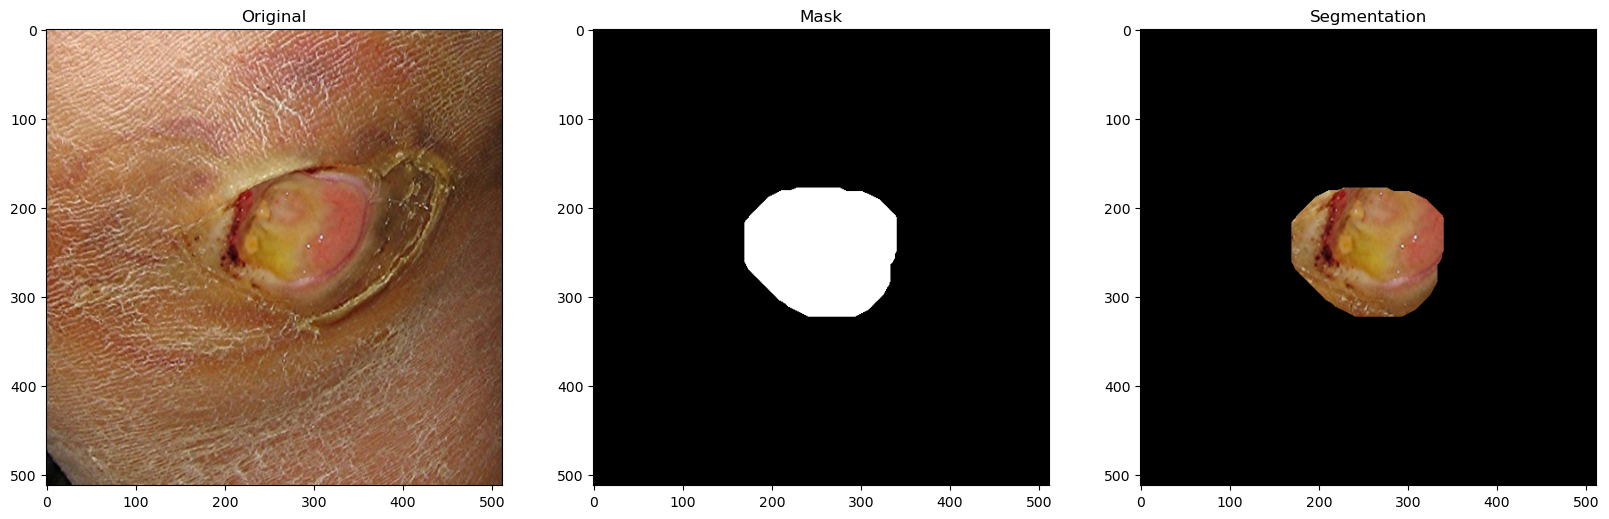

In [72]:
""" RESULTADO FINAL """
# Aplicamos la máscara y segmentamos
u7_segmented = u7_rgb * u7_mask[:,:,np.newaxis]
show_img_mask_and_segmentation(u7_rgb, u7_mask, u7_segmented)

## #8. U8

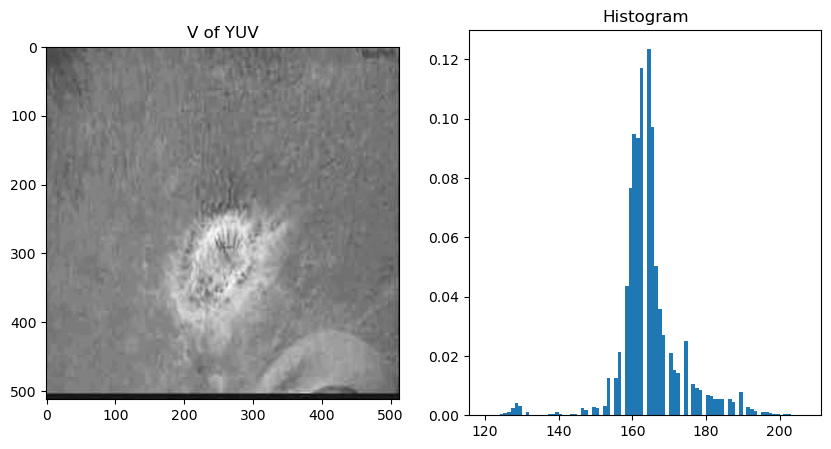

In [73]:
u8 = cv2.imread('Ulcers/U8.jpg')
u8_rgb = cv2.cvtColor(u8, cv2.COLOR_BGR2RGB)

# Se decide tras analizar los canales de color con el script, escoger el canal V de YUV
u8_v = cv2.cvtColor(u8, cv2.COLOR_BGR2YUV)[:,:,2]
show_img_channel_and_histogram(u8_v, 'V of YUV')

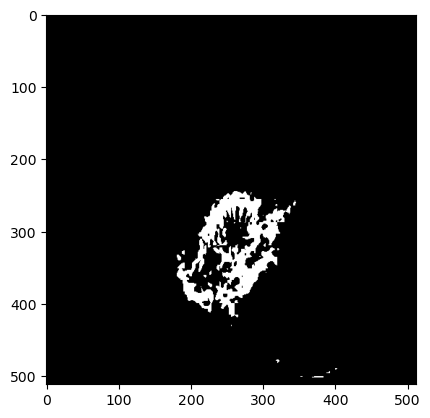

In [130]:
# Umbralización alta
_, u8_v_thr = cv2.threshold(u8_v, 183, 255, cv2.THRESH_BINARY)
plt.imshow(u8_v_thr, cmap='gray');

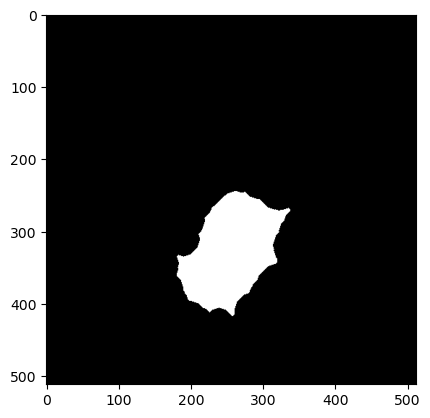

In [131]:
# Apertura para limpiar alrededores
se8 = morph.disk(2)
u8_v_op = cv2.morphologyEx(u8_v_thr, cv2.MORPH_OPEN, se8, iterations=1)
# Seguida de un cierre para definir la lesión
u8_v_cl = cv2.morphologyEx(u8_v_op, cv2.MORPH_CLOSE, morph.disk(7), iterations=3)
plt.imshow(u8_v_cl, cmap='gray');

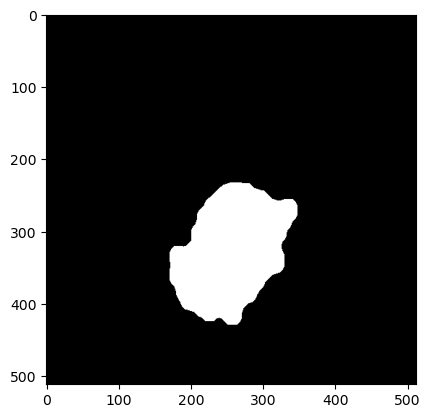

In [134]:
# Por último una dilatación para mejorar la máscara
u8_mask = cv2.dilate(u8_v_cl, morph.ellipse(5,6), iterations=2) > 127
plt.imshow(u8_mask, cmap='gray');

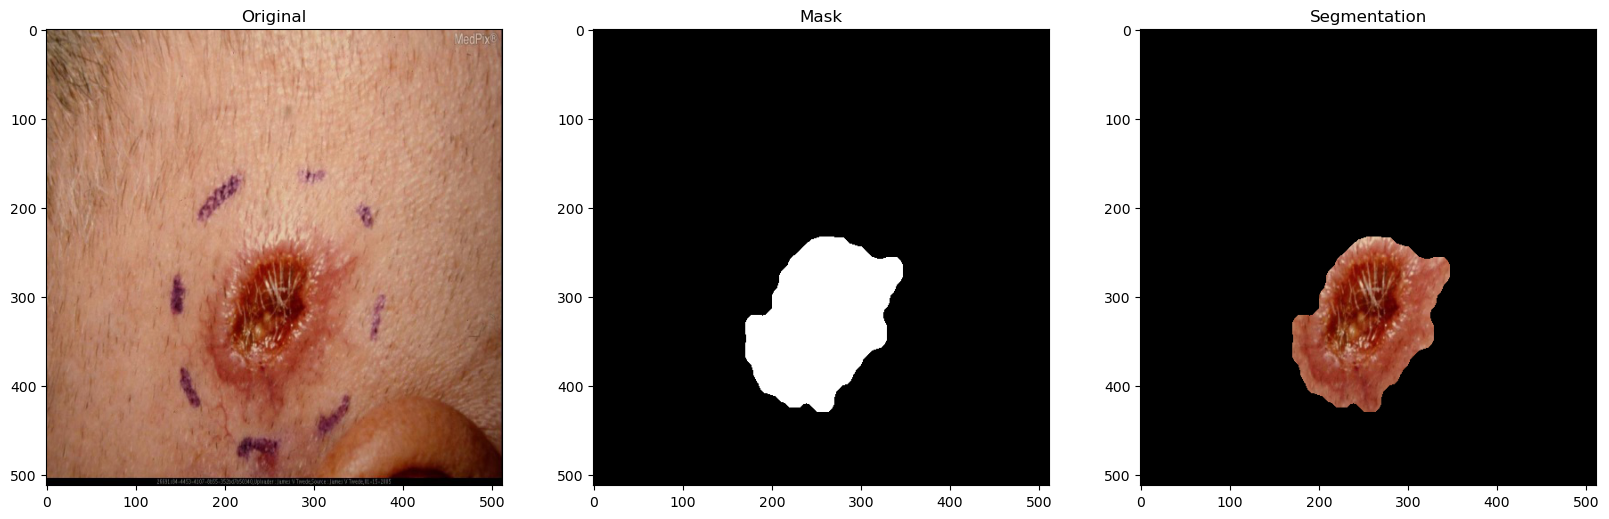

In [135]:
""" RESULTADO FINAL """
# Aplicamos la máscara y segmentamos
u8_segmented = u8_rgb * u8_mask[:,:,np.newaxis]
show_img_mask_and_segmentation(u8_rgb, u8_mask, u8_segmented)

## #9. U9

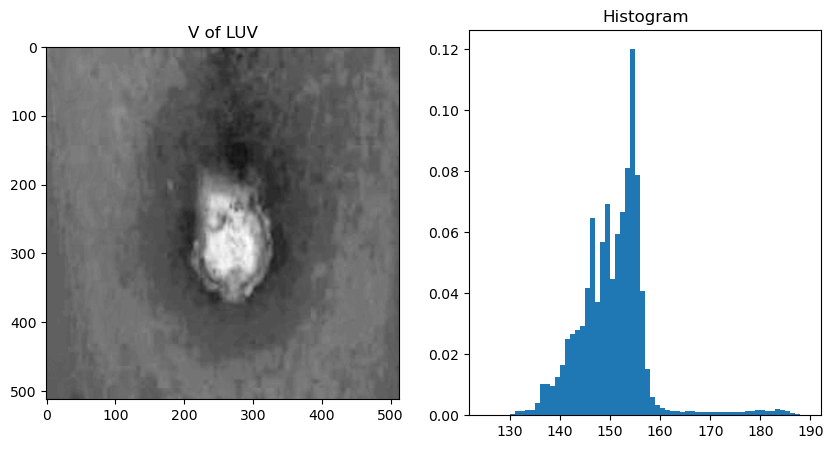

In [136]:
u9 = cv2.imread('Ulcers/U9.jpg')
u9_rgb = cv2.cvtColor(u9, cv2.COLOR_BGR2RGB)

# Escogemos el  V del LUV
u9_v = cv2.cvtColor(u9, cv2.COLOR_BGR2LUV)[:,:,2]
show_img_channel_and_histogram(u9_v, 'V of LUV')

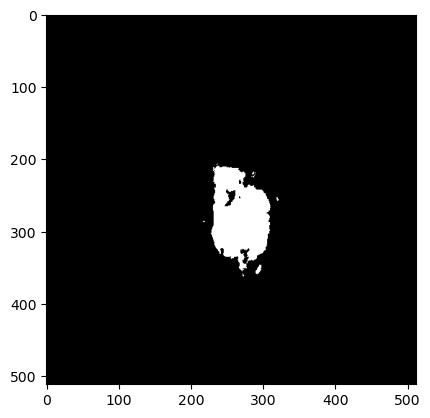

In [ ]:
# La lesión es de una región de alta intensidad, apliquemos un umbral de 162 según el hisograma
_, u9_v_thr = cv2.threshold(u9_v, 162, 255, cv2.THRESH_BINARY)
plt.imshow(u9_v_thr, cmap='gray');

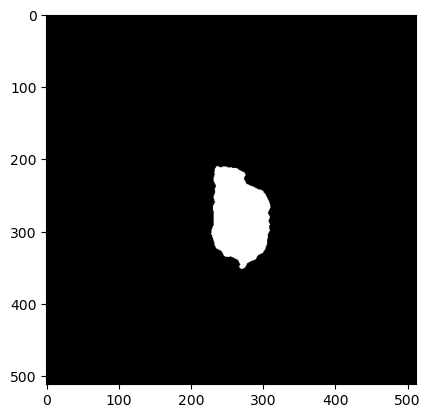

In [147]:
# Aplicamos una apertura para limpiar la imagen
se9 = morph.disk(3)
u9_v_op = cv2.morphologyEx(u9_v_thr, cv2.MORPH_OPEN, se9, iterations=1)
# Ahora un cierre
u9_v_cl = cv2.morphologyEx(u9_v_op, cv2.MORPH_CLOSE, se9, iterations=3)
plt.imshow(u9_v_cl, cmap='gray');

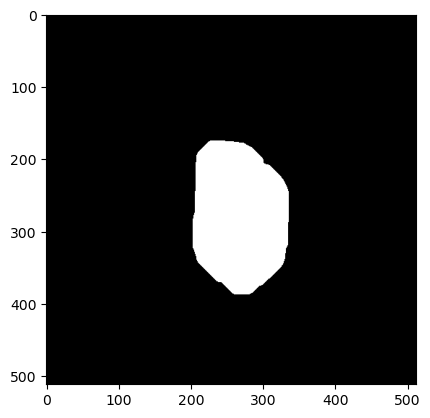

In [151]:
# Dilatación con estructura de elipse
u9_mask = cv2.dilate(u9_v_cl, morph.ellipse(5,7), iterations=5) > 127
plt.imshow(u9_mask, cmap='gray');

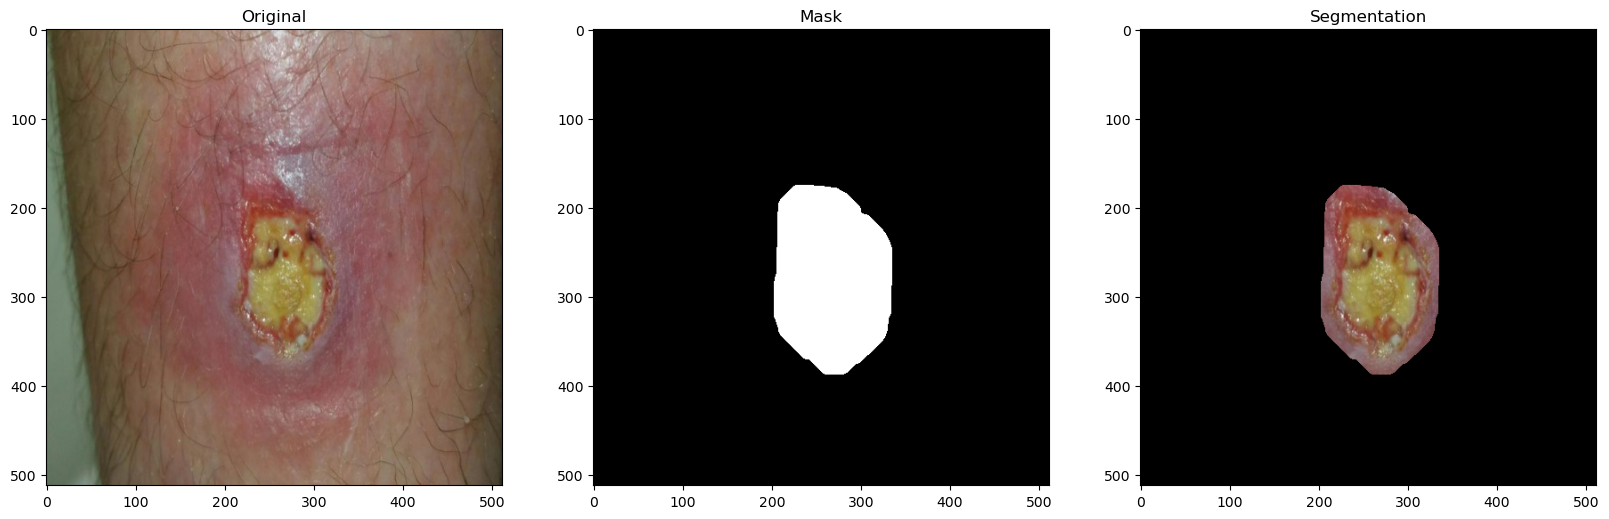

In [152]:
""" RESULTADO FINAL """
# Aplicamos la máscara y segmentamos
u9_segmented = u9_rgb * u9_mask[:,:,np.newaxis]
show_img_mask_and_segmentation(u9_rgb, u9_mask, u9_segmented)

## #10. U10

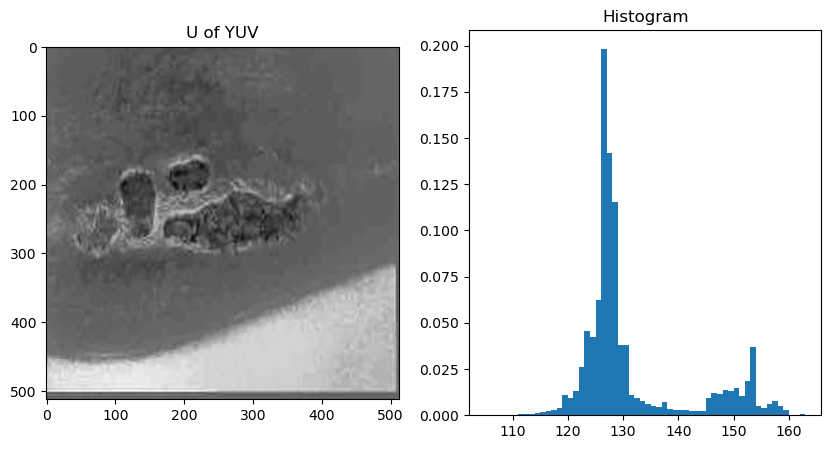

In [196]:
u10 = cv2.imread('Ulcers/U10.jpg')
u10_rgb = cv2.cvtColor(u10, cv2.COLOR_BGR2RGB)

# Escogemos canal U del YUV
u10_u = cv2.cvtColor(u10, cv2.COLOR_BGR2YUV)[:,:,1]
show_img_channel_and_histogram(u10_u, 'U of YUV')

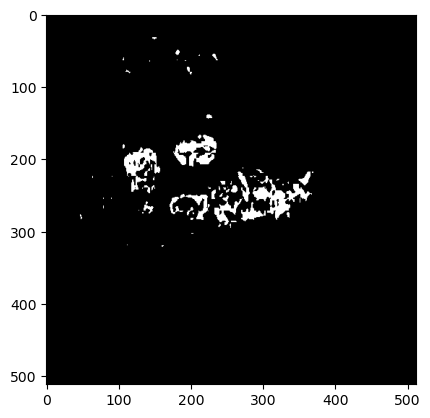

In [197]:
# Las lesiones están en una zona de baja intensidad, aplicamos un umbral de 120 invertido
_, u10_u_thr = cv2.threshold(u10_u, 119, 255, cv2.THRESH_BINARY_INV)
plt.imshow(u10_u_thr, cmap='gray');

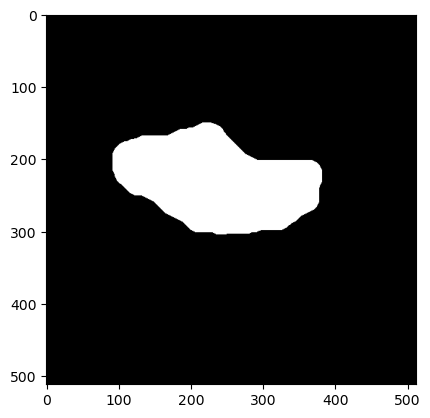

In [198]:
# Aplicamos una apertura para limpiar la imagen
se10 = morph.disk(3)
u10_u_op = cv2.morphologyEx(u10_u_thr, cv2.MORPH_OPEN, se10, iterations=1)
# Ahora un cierre para unir las lesiones, usando una estructura de elipse
u10_u_cl = cv2.morphologyEx(u10_u_op, cv2.MORPH_CLOSE, morph.ellipse(9,7), iterations=10)
# Ahora unas cuantas dilataciones para mejorar la máscara
u10_mask = cv2.dilate(u10_u_cl, morph.ellipse(8,9), iterations=2) > 127
plt.imshow(u10_mask, cmap='gray');

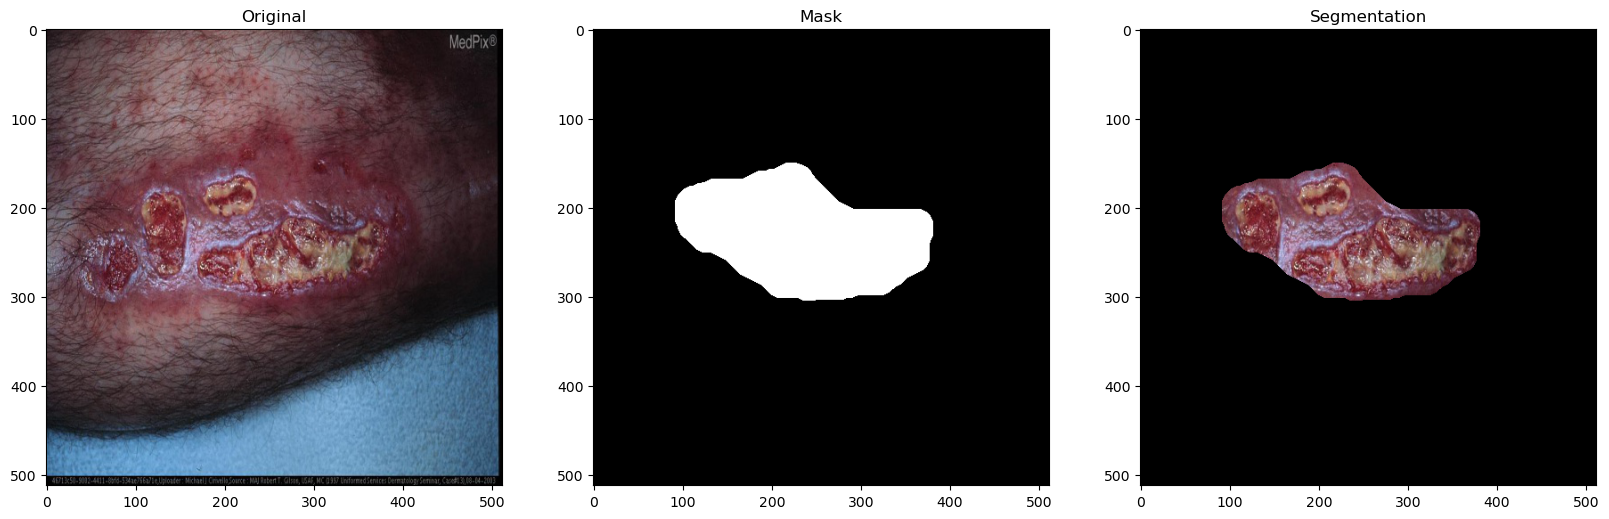

In [199]:
""" RESULTADO FINAL """
# Aplicamos la máscara y segmentamos
u10_segmented = u10_rgb * u10_mask[:,:,np.newaxis]
show_img_mask_and_segmentation(u10_rgb, u10_mask, u10_segmented)

## #11. U11

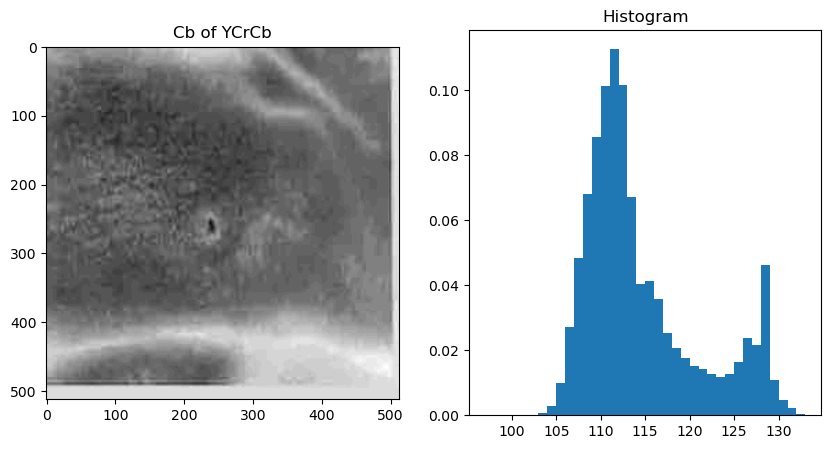

In [200]:
u11 = cv2.imread('Ulcers/U11.jpg')
u11_rgb = cv2.cvtColor(u11, cv2.COLOR_BGR2RGB)

# Escogemos el Cb del YCrCb
u11_cb = cv2.cvtColor(u11, cv2.COLOR_BGR2YCrCb)[:,:,2]
show_img_channel_and_histogram(u11_cb, 'Cb of YCrCb')

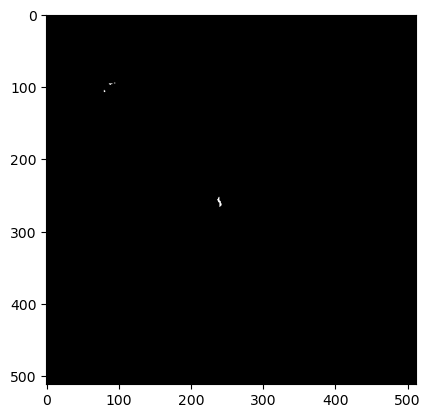

In [212]:
# La lesión está en una región de baja intensidad, aplicamos un umbral de 120 invertido
_, u11_cb_thr = cv2.threshold(u11_cb, 102, 255, cv2.THRESH_BINARY_INV)
plt.imshow(u11_cb_thr, cmap='gray');

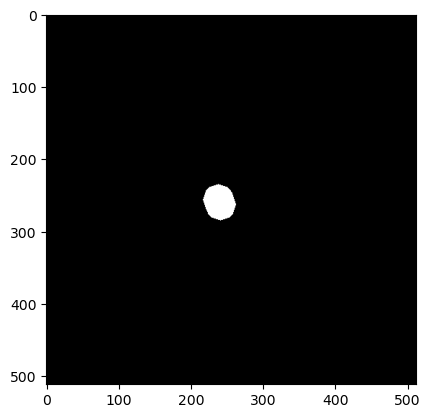

In [218]:
# Aplicamos una apertura pequeña para limpiar la imagen
u11_cb_op = cv2.morphologyEx(u11_cb_thr, cv2.MORPH_OPEN, morph.disk(1), iterations=1)
# Tenuamente tenemos la forma de la lesión, aplicamos entonces una dilatación de elipse vertical para recuperar la forma
u11_mask = cv2.dilate(u11_cb_op, morph.disk(5), iterations=4) > 127
plt.imshow(u11_mask, cmap='gray');

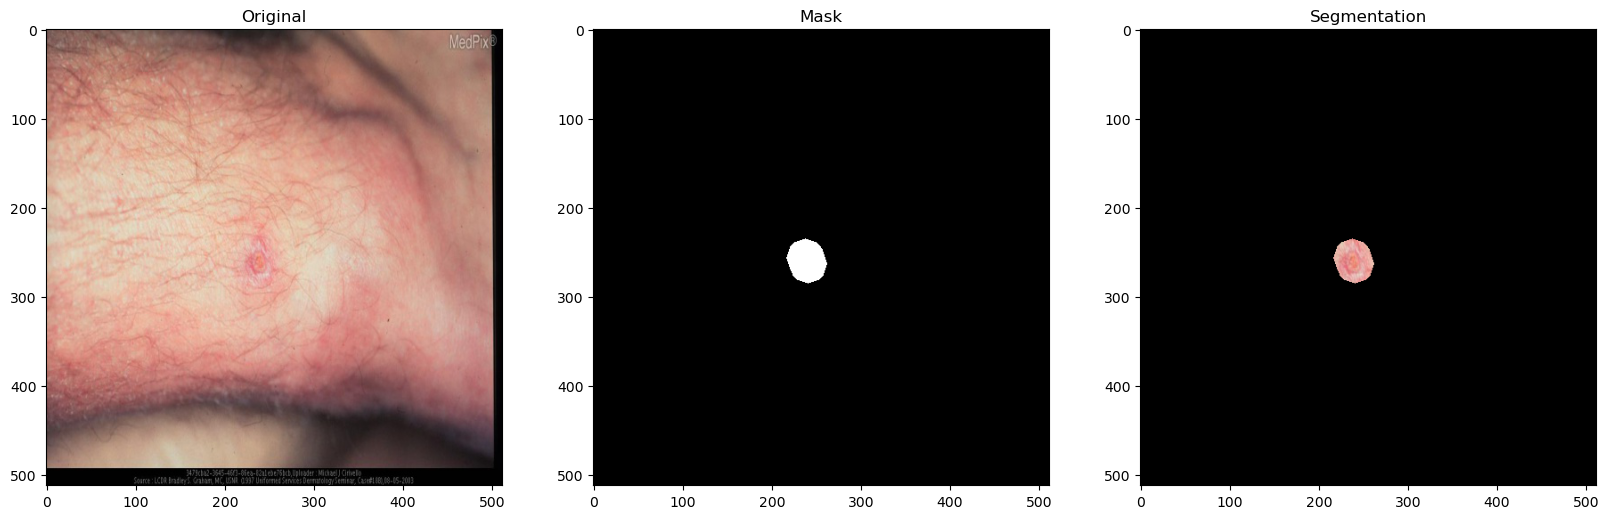

In [219]:
""" RESULTADO FINAL """
# Aplicamos la máscara y segmentamos
u11_segmented = u11_rgb * u11_mask[:,:,np.newaxis]
show_img_mask_and_segmentation(u11_rgb, u11_mask, u11_segmented)

## #12. U12

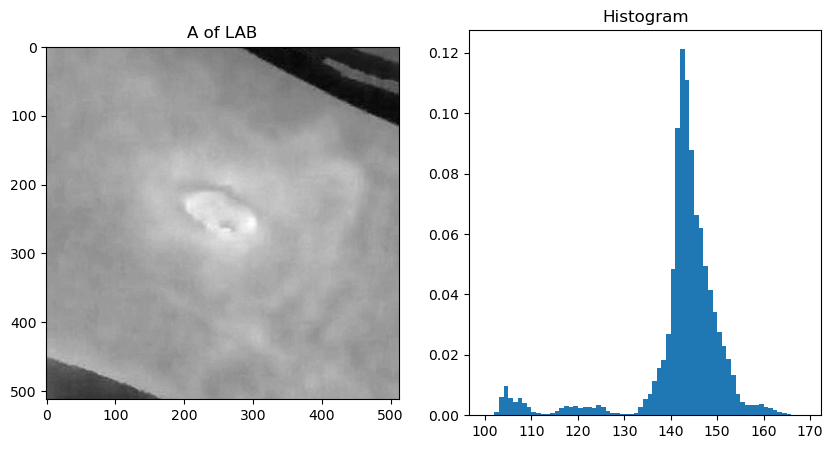

In [221]:
u12 = cv2.imread('Ulcers/U12.png')
u12_rgb = cv2.cvtColor(u12, cv2.COLOR_BGR2RGB)

# Escogemos el canal A del LAB
u12_a = cv2.cvtColor(u12, cv2.COLOR_BGR2LAB)[:,:,1]
show_img_channel_and_histogram(u12_a, 'A of LAB')

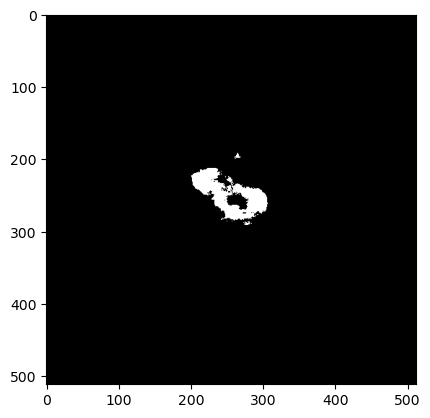

In [332]:
# La lesión está en una región de alta intensidad, aplicamos un umbral de 160
_, u12_a_thr = cv2.threshold(u12_a, 158, 255, cv2.THRESH_BINARY)
plt.imshow(u12_a_thr, cmap='gray');

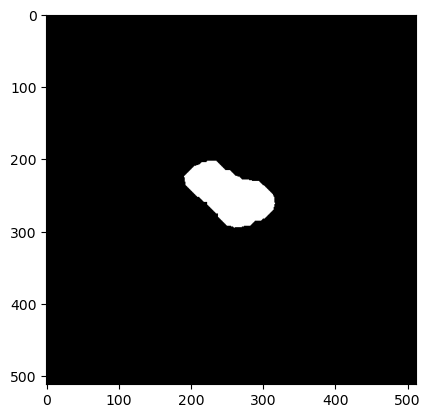

In [333]:
# Primero una pequeña paertura para limpiar la imagen
u12_a_op = cv2.morphologyEx(u12_a_thr, cv2.MORPH_OPEN, morph.disk(2), iterations=1)
# Aplicamos un cierre para dejar bien definida el área de la lesion
u12_a_cl = cv2.morphologyEx(u12_a_op, cv2.MORPH_CLOSE, morph.ellipse(4,6), iterations=4)
# Ahora una dilatación para mejorar la máscara
u12_mask = cv2.dilate(u12_a_cl, morph.disk(2), iterations=5) > 127
plt.imshow(u12_mask, cmap='gray');

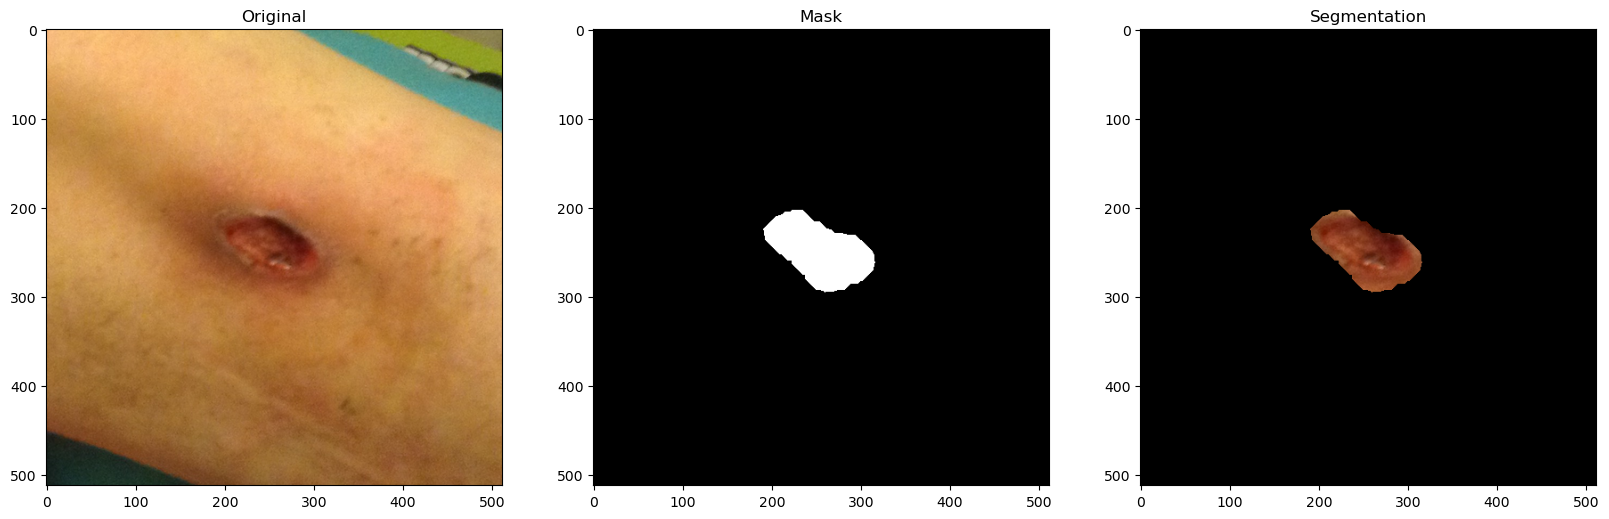

In [334]:
""" RESULTADO FINAL """
# Aplicamos la máscara y segmentamos
u12_segmented = u12_rgb * u12_mask[:,:,np.newaxis]
show_img_mask_and_segmentation(u12_rgb, u12_mask, u12_segmented)

## #13. U13

In [ ]:
u13 = cv2.imread('Ulcers/U13.jpg')
u13_rgb = cv2.cvtColor(u13, cv2.COLOR_BGR2RGB)

# Escogemos el canal V del YUV